In [24]:
import torch as th
import numpy as np
import pickle
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from pytorch_lightning import seed_everything
import torch as th
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sys
sys.path.insert(0, '../../../sample_scripts/')
import glob
import warnings
warnings.filterwarnings("ignore")

# from sample_scripts.sample_utils.inference_utils import to_tensor
from sample_scripts.sample_utils.vis_utils import plot_image
from sample_scripts.sample_utils import (
    ckpt_utils, 
    file_utils,
    params_utils,
)
from guided_diffusion.dataloader.img_deca_datasets import load_data_img_deca

device = 'cuda:0'

plt.rcParams["savefig.bbox"] = 'tight'

from importlib import reload
sys.path.insert(0, '../../../sample_scripts/cond_utils/DECA/')
from decalib.deca import DECA
from decalib.datasets import datasets 
from decalib.utils import util
from decalib.utils.config import cfg as deca_cfg
from decalib.utils.tensor_cropper import transform_points

def show(imgs, size=17):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(size, size))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def get_cfg(self):
    from config.base_config import parse_args
    cfg_file_path = glob.glob("/home/mint/guided-diffusion/config/*/*", recursive=True)
    cfg_file_path = [cfg_path for cfg_path in cfg_file_path if f"/{self.cfg_name}" in cfg_path]    # Add /{}/ to achieve a case-sensitive of folder
    print("[#] Config Path : ", cfg_file_path)
    assert len(cfg_file_path) <= 1
    assert len(cfg_file_path) > 0
    cfg_file = cfg_file_path[0]
    cfg = parse_args(ipynb={'mode':True, 'cfg':cfg_file})
    return cfg

def gen_shadow_mask_vert(ld, depth_grid, vis=True, up_rate=1):
    # print(ld.shape, depth_grid.shape)
    depth_grid[:, :, 2] *= (256 * up_rate)
    ray = ld.view(3)
    ray[2] *= 0.5

    shadow_mask = th.clone(depth_grid[:, :, 2])
    n = 256 * up_rate
    # print("[#] Ray before normalization : ", ray)
    ray = ray / th.norm(ray)
    # print("[#] Ray after normalization : ", ray)
    mxaxis = max(abs(ray[0]), abs(ray[1]))
    shift = ray / mxaxis * th.arange(n).view(n, 1)
    coords = depth_grid.view(1, n, n, 3) + shift.view(n, 1, 1, 3)

    output = th.nn.functional.grid_sample(
      th.tensor(np.tile(depth_grid[:, :, 2].view(1, 1, n, n), [n, 1, 1, 1])),
      coords[..., :2] / (n - 1) * 2 - 1,
      align_corners=True)
    diff = coords[..., 2] - output[:, 0] 
    shadow_mask *= (th.min(diff, dim=0)[0] > -0.1) * 0.5 + 0.5
    
    return shadow_mask

def sh_to_ld(sh):
    
    #NOTE: Roughly Convert the SH to light direction
    sh = sh.reshape(-1, 9, 3)
    print("[#] SH : ", sh)
    ld = th.mean(sh[0:1, 1:4, :], dim=2)
    print("[#] Light direction : ", ld)
    return ld

def create_image_grid(images, n_rows=1, text_labels=[]):
    """
    Creates a grid of images from a list of NumPy arrays.
    
    Parameters:
    - images: List of np.array, each representing an image.
    - n_rows: Number of rows in the grid.
    
    Returns:
    - A matplotlib figure containing the image grid.
    """
    n_images = len(images)
    n_cols = (n_images + n_rows - 1) // n_rows  # Calculate number of columns needed
    
    # Get the height and width of the images (assuming all images are the same size)
    # img_height, img_width = images[0].shape[:2]

    # Add zero images if the number of images is less than needed to fill the grid
    images += [np.zeros_like(images[0]) for _ in range(n_rows * n_cols - n_images)]
    
    # Create the grid by concatenating images
    rows = []
    for i in range(n_rows):
        row_images = images[i * n_cols:(i + 1) * n_cols]
        rows.append(np.concatenate(row_images, axis=1))
    
    grid_image = np.concatenate(rows, axis=0)

    # Add text labels to the grid
    img_height, img_width = images[0].shape[:2]
    for i, text_label in enumerate(text_labels):
        # plt.text((i % n_cols) * img_width, (i // n_cols) * img_height, text_label, color='red', fontsize=12)
        if isinstance(text_label, str):
            plt.text((i % n_cols) * img_width + img_width/4, -2, text_label, color='red', fontsize=20)
        else:
            plt.text((i % n_cols) * img_width + img_width/4, -2, f'{float(text_label):.5f}', color='red', fontsize=20)

    return grid_image




In [20]:

ckpt_loader = ckpt_utils.CkptLoader(log_dir="Masked_Face_woclip+BgNoHead+shadow_256", cfg_name="Masked_Face_woclip+BgNoHead+shadow_256.yaml")
cfg = ckpt_loader.cfg
cfg.img_model.image_size = 256
# Load dataset
dataset = 'ffhq'
set_ = 'valid'
img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
# Load dataset
if dataset == 'itw':
    cfg.dataset.root_path = f'/data/mint/DPM_Dataset/'
    img_dataset_path = f"/data/mint/DPM_Dataset/ITW/itw_images_aligned/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/ITW/params/"
    img_ext = '.png'
    cfg.dataset.training_data = 'ITW'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/itw_images_aligned/'
elif dataset == 'ffhq':
    cfg.dataset.root_path = f'/data/mint/DPM_Dataset/'
    img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
    img_ext = '.jpg'
    cfg.dataset.training_data = 'ffhq_256_with_anno'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/ffhq_256/'
elif dataset in ['mp_valid', 'mp_test', 'mp_test2']:
    if dataset == 'mp_test':
        sub_f = '/MultiPIE_testset/'
    elif dataset == 'mp_test2':
        sub_f = '/MultiPIE_testset2/'
    elif dataset == 'mp_valid':
        sub_f = '/MultiPIE_validset/'
    else: raise ValueError
    img_dataset_path = f"/data/mint/DPM_Dataset/MultiPIE/{sub_f}/mp_aligned/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/MultiPIE/{sub_f}/params/"
    img_ext = '.png'
    cfg.dataset.training_data = f'/MultiPIE/{sub_f}/'
    cfg.dataset.root_path = f'/data/mint/DPM_Dataset/'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/mp_aligned/'
else: raise ValueError

cfg.dataset.deca_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/params/'
cfg.dataset.face_segment_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/face_segment/"
cfg.dataset.deca_rendered_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/rendered_images/"
cfg.dataset.laplacian_mask_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/eyes_segment/"
cfg.dataset.laplacian_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/laplacian/"

loader, dataset, _ = load_data_img_deca(
    data_dir=img_dataset_path,
    deca_dir=deca_dataset_path,
    batch_size=int(1e7),
    image_size=cfg.img_model.image_size,
    deterministic=cfg.train.deterministic,
    augment_mode=cfg.img_model.augment_mode,
    resize_mode=cfg.img_model.resize_mode,
    in_image_UNet=cfg.img_model.in_image,
    params_selector=cfg.param_model.params_selector + ['albedo'],
    rmv_params=cfg.param_model.rmv_params,
    set_=set_,
    cfg=cfg,
)

f_mask = np.load('./FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
v_mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
mask={
    'v_mask':v_mask['face'].tolist(),
    'f_mask':f_mask['face'].tolist()
}

deca_cfg.model.extract_tex = True
deca_cfg.rasterizer_type = 'standard'
deca_cfg.model.use_tex = True 
deca = DECA(config = deca_cfg, device='cuda', mode='shape', mask=mask)

img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/{set_}/")
img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=['60065.jpg'])
# img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=['60065.jpg', '60000.jpg', '60001.jpg', '60002.jpg', '60004.jpg'])
dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=1,
                                    shuffle=False, num_workers=24)
                            
dat, model_kwargs = next(iter(subset_loader))
print(model_kwargs.keys())
rendered_image, orig_visdict = params_utils.render_deca(deca_params=model_kwargs, 
                                                        idx=0, n=len(img_idx), 
                                                        useTex=True, extractTex=True, 
                                                        deca_mode='', use_detail=True, mask=mask, repeat=False, 
                                                        deca_obj=deca)
print(orig_visdict.keys())


[#] Model Path : 
#0 : /data/mint/model_logs_mount/ist-cluster-figure/Masked_Face_woclip+BgNoHead+shadow_256/
[#] Config Path :  ['/home/mint/Dev/DiFaReli/difareli-faster/config/Baseline/Masked_Face_woclip+BgNoHead+shadow_256.yaml']
Merging with :  Namespace(cfg='/home/mint/Dev/DiFaReli/difareli-faster/config/Baseline/Masked_Face_woclip+BgNoHead+shadow_256.yaml')

[#] Load data of valid from path...
1. Face segment dir :  /data/mint/DPM_Dataset//ffhq_256_with_anno/face_segment/
2. Deca rendered dir :  /data/mint/DPM_Dataset//ffhq_256_with_anno/rendered_images/
3. Shadow diff dir :  /data/mint/DPM_Dataset//ffhq_256_with_anno/shadow_diff/


Loading deca params...: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


[#] Bounding the input of UNet to +-1.0
[#] Parameters Conditioning
Params keys order :  ['shape', 'pose', 'exp', 'cam', 'faceemb', 'shadow']
Remove keys :  []
Input Image :  ['raw']
Image condition :  ['deca_masked_face_images_woclip', 'faceseg_nohead']
DPM Image condition :  [None]
creating the FLAME Decoder
trained model found. load /home/mint/Dev/DiFaReli/difareli-faster/sample_scripts/cond_utils/DECA/data/deca_model.tar
USING STARDARD...
/home/mint/Dev/DiFaReli/difareli-faster/experiment_scripts/TPAMI/anti_aliasing/../../../sample_scripts/cond_utils/DECA/decalib/utils
[#] DECA : SRenderY applied mask
dict_keys(['deca_masked_face_images_woclip_img', 'faceseg_nohead_img', 'faceseg_nohead_mask', 'cond_params', 'shadow', 'shape', 'pose', 'exp', 'cam', 'light', 'faceemb', 'tform', 'albedo', 'detail', 'image_name', 'raw_image', 'raw_image_path', 'image'])
1 1
dict_keys(['inputs', 'landmarks2d', 'landmarks3d', 'shape_images', 'shape_detail_images', 'albedo_images', 'normal_images', 'rend

[#] SH :  tensor([[[ 3.4064,  3.4182,  3.4240],
         [ 0.2447,  0.2731,  0.2787],
         [ 0.3633,  0.3744,  0.3737],
         [-0.5315, -0.5115, -0.4969],
         [-0.0280, -0.0261, -0.0255],
         [ 0.1553,  0.1721,  0.1742],
         [ 0.5656,  0.5742,  0.5729],
         [ 0.2513,  0.2558,  0.2585],
         [ 0.7326,  0.7334,  0.7377]]], dtype=torch.float64)
[#] Light direction :  tensor([[ 0.2655,  0.3705, -0.5133]], dtype=torch.float64)
[#] Transformed light direction :  tensor([[[ 2.8537, -4.4644,  5.4243]]], dtype=torch.float64)
[#] MESHGRID's shape :  (256, 256, 2)
[#] DEPTH_GRID's shape:  (256, 256, 3)
[#] SHADOW_MASK's shape :  torch.Size([256, 256])
[#] min = 0.0, max = 255.91607666015625


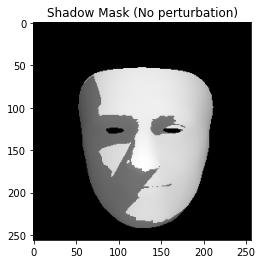

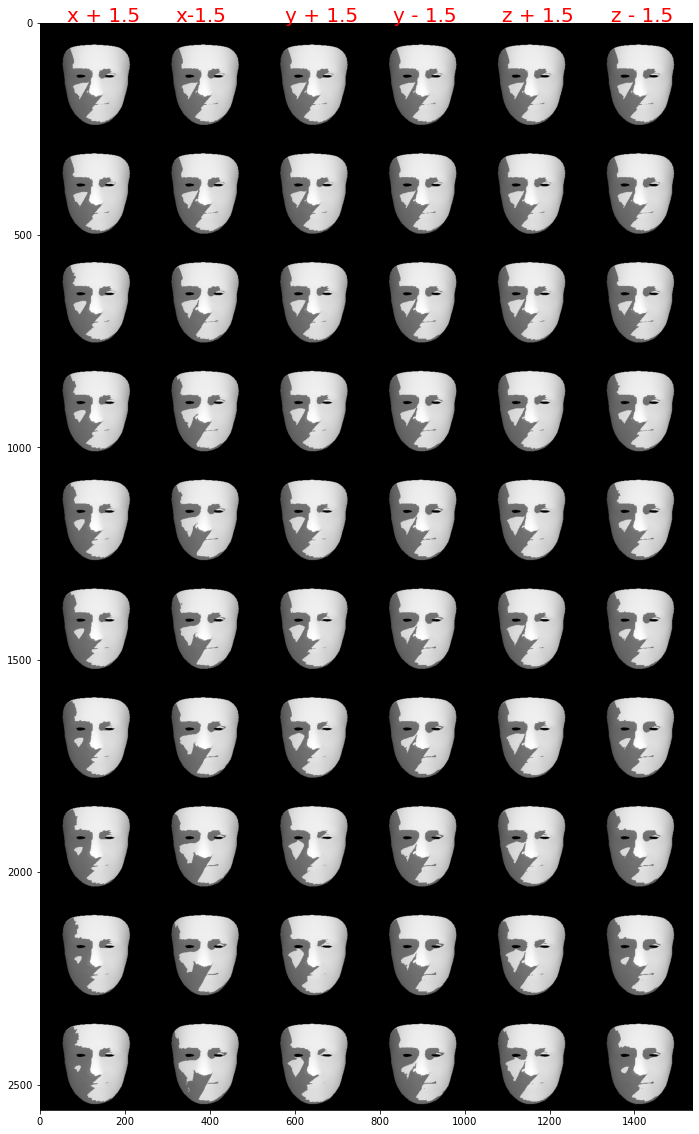

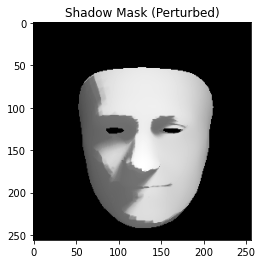

In [26]:
up_rate = 1
os.makedirs('./perturb_ld/', exist_ok=True)
ld = sh_to_ld(sh=model_kwargs['light']).cpu().numpy()[None, ...]
ld = th.tensor(ld)
ld = util.batch_orth_proj(th.tensor(ld), model_kwargs['cam']); ld[:,:,1:] = -ld[:,:,1:]
print("[#] Transformed light direction : ", ld)

depth_image, alpha_image = deca.render.render_depth(orig_visdict['trans_verts_orig'], up_rate=up_rate)
depth_image = depth_image.repeat(1,3,1,1)
alpha_image = alpha_image.repeat(1,3,1,1)
_, _, h, w = depth_image.shape
depth_grid = np.meshgrid(np.arange(h), np.arange(w), indexing='xy')
depth_grid = np.stack((depth_grid), axis=-1)
print("[#] MESHGRID's shape : ", depth_grid.shape)
depth_grid = np.concatenate((depth_grid, depth_image[0].permute(1, 2, 0)[..., 0:1].cpu().numpy()), axis=-1)
print("[#] DEPTH_GRID's shape: ", depth_grid.shape)
torchvision.utils.save_image(depth_image, f'./perturb_ld/out_depth_AAx{up_rate}.png')

shadow_mask = gen_shadow_mask_vert(ld.detach().clone(), th.tensor(depth_grid.reshape(h, w, 3)), vis=True)
print("[#] SHADOW_MASK's shape : ", shadow_mask.shape)
print(f"[#] min = {th.min(shadow_mask)}, max = {th.max(shadow_mask)}")
torchvision.utils.save_image(shadow_mask/(256.0*up_rate), f'./perturb_ld/out_sd_AAx{up_rate}.png')
shadow_mask = shadow_mask.cpu().numpy() / (256.0*up_rate)
plt.imshow(shadow_mask, cmap='gray')
plt.title("Shadow Mask (No perturbation)")
plt.show()

sd_perturb = []
# eps_perturb = 0.5
# eps_perturb = 0

for pt in np.linspace(0, 1.5, 10):
    eps_perturb = pt
    for i in range(3):
        ld_perturb = ld.detach().clone()
        ld_perturb[..., i] += eps_perturb
        sd_perturb.append(gen_shadow_mask_vert(ld_perturb.clone(), th.tensor(depth_grid.reshape(h, w, 3)), vis=False))
        ld_perturb[..., i] -= 2*eps_perturb
        sd_perturb.append(gen_shadow_mask_vert(ld_perturb.clone(), th.tensor(depth_grid.reshape(h, w, 3)), vis=False))

for i in range(len(sd_perturb)):
    sd_perturb[i] = sd_perturb[i].cpu().numpy() / (256.0*up_rate)

fig = plt.figure(figsize=(20, 20))
plt.imshow(create_image_grid(sd_perturb, text_labels=[f'x + {eps_perturb}', f'x-{eps_perturb}', f'y + {eps_perturb}', f'y - {eps_perturb}', f'z + {eps_perturb}', f'z - {eps_perturb}'], n_rows=len(sd_perturb)//6), cmap='gray')
plt.show()
plt.savefig(f'./perturb_ld/out_sd_perturb_AAx{up_rate}.png')

final_sd = np.stack(sd_perturb, axis=0)
final_sd = np.mean(final_sd, axis=0)
plt.imshow(final_sd, cmap='gray')
plt.title("Shadow Mask (Perturbed)")
plt.show()

plt.imshow(np.concatenate([shadow_mask, final_sd], axis=1), cmap='gray')
plt.title("Shadow Mask (No Perturbation) vs Shadow Mask (Perturbed)")
plt.show()